# pybacktest tutorial

This tutorial will give you a quick overview of **pybacktest**'s features. To do so, we will backtest classic MA crossover trading strategy:

* go long when short MA crosses above long MA
* go short when short MA crosses below long MA
* entry rules are also exit rules, thus making strategy reversible

Package is available for download at https://github.com/ematvey/pybacktest

In [1]:
%matplotlib inline
import pybacktest  # obviously, you should install pybacktest before importing it
import pandas as pd
import matplotlib.pyplot as plt  

E:\workspace\pythonSpace\anaconda\lib\site-packages\pandas\io\data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


**pybacktest** expects bars to be in `pandas.DataFrame` indexed by datetimestamps, with columns named `O`, `H`, `L`, `C`. Actually, in this version it would only check `O`, and only if trade prices are not explicitly specified.

Lets load data from yahoo using helper.

In [2]:
ohlc = pybacktest.load_from_yahoo('SPY')
ohlc.tail()

,O,H,L,C,V,AC
Date,,,,,,
2016-01-12,193.820007,194.550003,191.139999,193.660004,172330500,193.660004
2016-01-13,194.449997,194.860001,188.380005,188.830002,221168900,188.830002
2016-01-14,189.550003,193.259995,187.660004,191.929993,240795600,191.929993
2016-01-15,186.770004,188.759995,185.520004,187.809998,324846400,187.809998
2016-01-19,189.960007,190.110001,186.199997,188.059998,190196000,188.059998


Now time to define strategy. To do so, all we need to do is to create binary `Series` with signals, and, optionally, trade price `Series` with float elements.

Could this be any simpler?

In [3]:
short_ma = 50
long_ma = 200

ms = pd.rolling_mean(ohlc.C, short_ma)
ml = pd.rolling_mean(ohlc.C, long_ma)
    
buy = cover = (ms > ml) & (ms.shift() < ml.shift())  # ma cross up
sell = short = (ms < ml) & (ms.shift() > ml.shift())  # ma cross down

print('> Short MA\n%s\n' % ms.tail())
print('>  Long MA\n%s\n' % ml.tail())
print ('>  Buy/Cover signals\n%s\n' % buy.tail())
print ('>  Short/Sell signals\n%s\n' % sell.tail())


> Short MA
Date
2016-01-12    205.423799
2016-01-13    205.041800
2016-01-14    204.672600
2016-01-15    204.208799
2016-01-19    203.762799
Name: C, dtype: float64

>  Long MA
Date
2016-01-12    205.79090
2016-01-13    205.69380
2016-01-14    205.62130
2016-01-15    205.53185
2016-01-19    205.43995
Name: C, dtype: float64

>  Buy/Cover signals
Date
2016-01-12    False
2016-01-13    False
2016-01-14    False
2016-01-15    False
2016-01-19    False
Name: C, dtype: bool

>  Short/Sell signals
Date
2016-01-12    False
2016-01-13    False
2016-01-14    False
2016-01-15    False
2016-01-19    False
Name: C, dtype: bool



Time to run backtest. `Backtest` will try to extract signals and prices and bars from whatever dict-like object you passed as first argument. Could be dict, could be pandas.DataFrame or anything.

To make thing easier, pass local namespace (extracted py calling `locals()`), that contains every variable you created up to this point.

In [4]:
bt = pybacktest.Backtest(locals(), 'ma_cross')

`Backtest` runs lazily, i.e. it calculates anything only when you call properties from it. There properties: 

In [5]:
print (filter(lambda x: not x.startswith('_'), dir(bt)))
print( '\n>  bt.signals\n%s' % bt.signals.tail())
print('\n>  bt.trades\n%s' % bt.trades.tail())
print ('\n>  bt.positions\n%s' % bt.positions.tail())
print ('\n>  bt.equity\n%s' % bt.equity.tail())
print ('\n>  bt.trade_price\n%s' % bt.trade_price.tail())


>  bt.signals
              Buy  Cover   Sell  Short
Date                                  
2016-01-12  False  False  False  False
2016-01-13  False  False  False  False
2016-01-14  False  False  False  False
2016-01-15  False  False  False  False
2016-01-19  False  False  False  False

>  bt.trades
            pos       price  vol
Date                            
2011-08-15   -1  119.190002   -2
2012-02-01    1  132.289993    2
2015-08-31   -1  198.110001   -2
2015-12-18    1  202.770004    2
2016-01-12   -1  193.820007   -2

>  bt.positions
Date
2011-08-12   -1
2012-01-31    1
2015-08-28   -1
2015-12-17    1
2016-01-11   -1
dtype: float64

>  bt.equity
Date
2011-08-15     0.050003
2012-02-01   -13.099991
2015-08-31    65.820008
2015-12-18    -4.660003
2016-01-12    -8.949997
dtype: float64

>  bt.trade_price
Date
2016-01-12    193.820007
2016-01-13    194.449997
2016-01-14    189.550003
2016-01-15    186.770004
2016-01-19    189.960007
Name: O, dtype: float64


Some of popular performance statistics could be requested by calling `summary` method of `Backtest`.

In [6]:
bt.summary()

------------------------------------------
|  Backtest(ma_cross, 2016-20-01 23:05)  |
------------------------------------------ 

{'exposure': {'trades/month': 1.0526}, 'risk/return profile': {'sortino': 2.0710999999999999, 'sharpe': 0.45129999999999998, 'WCDD (monte-carlo 0.99 quantile)': 59.277299999999997, 'maxdd': 29.059999999999999, 'MPI': 1.2595000000000001, 'UPI': 1.1964999999999999}, 'backtest': {'days': 7789, 'from': '1994-09-15 00:00:00', 'trades': 20, 'to': '2016-01-12 00:00:00'}, 'performance': {'payoff': 3.4113000000000002, 'PF': 4.1692999999999998, 'profit': 231.06880000000001, 'RF': 7.9513999999999996, 'averages': {'trade': 11.5534, 'gain': 27.6343, 'loss': -8.1008999999999993}, 'winrate': 0.55}}
------------------------------------------


Now lets look at equity curve.

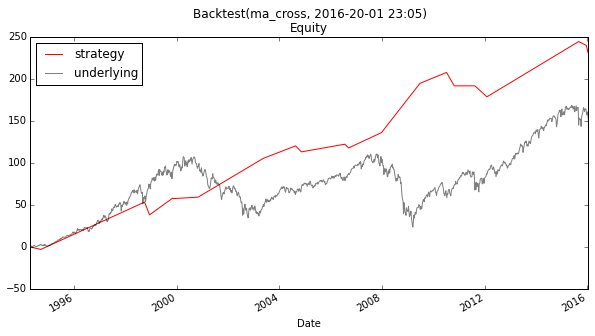

In [7]:
plt.figure(figsize=(10,5))
bt.plot_equity()

But what if you want to see what exactly was going on during backtest run? Well, `Backtest` can plot trades as they happened for you. Legend is hidden by default to save space.

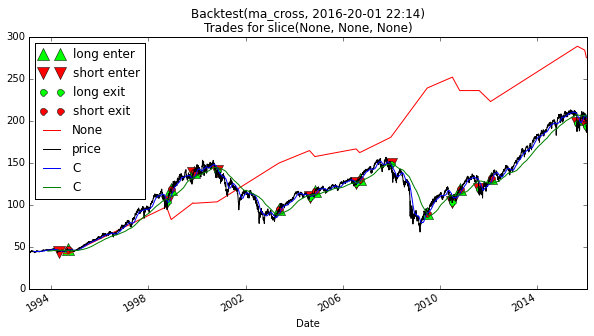

In [36]:
plt.figure(figsize=(10,5))
bt.plot_trades()
pd.rolling_mean(ohlc.C, short_ma).plot(c='green')
pd.rolling_mean(ohlc.C, long_ma).plot(c='blue')
plt.legend(loc='upper left')

Can you see anything there? I can't. That's why we have special a very special `trdplot` property, which allowes you specify what period do you want to plot using standard `pandas` indexing mechanisms. Same trick could be done with equity curve using `eqplot` property.

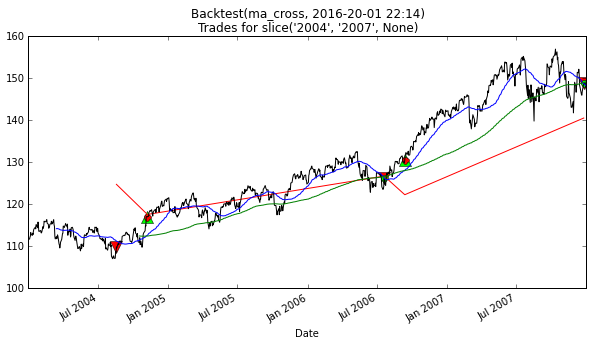

In [37]:
plt.figure(figsize=(10,5))
bt.trdplot['2004':'2007']
pd.rolling_mean(ohlc.C['2004':'2007'], short_ma).plot(c='green')
pd.rolling_mean(ohlc.C['2004':'2007'], long_ma).plot(c='blue')

That's the most of it. Next tutorial would be on more advanced features.